# SC Trade Optimization

## Introduction
In many simulation games, there is an element of trade. Typically, the player visits
various producers, which sells a certain set of good for a low price, and then delivers the
goods to various consumers, which would purchase the goods for a higher price. A natural
in these cases would be to maximize the profit after a successful run. For this analysis, the
focus is on Star Citizen, which is a space sim game currently in development. In SC, each outposts on planets/moons, and space stations has a list of goods that they would sell
and purchase. For instance, a mining outposts would sell various minerals while buying things like
medical supplies. Often, the producing location would sell the goods at a cheaper price. Thus, a
trading strategy would be to purchase goods from the producing locations to sell in major hubs like
space stations or cities. Thus, the goal would be to determine the optimal producers/consumers to
visit, and the amount to purchase/sell.

## Motivation
Currently, there are existing tools which can be used to find trade routes. However, these tools
are usually unable to find routes that span over multiple locations while carrying multiple types
of cargo. Furthermore, given the current state of supply in the game, the existing tools are also
unable to account for the expected low supply on highly profitable goods. Thus, by explicitly modeling
the problem in the language of optimization, some of these issues may be addressed.

## Problem Description
Since SC is a space sim, there are no "roads" that has to be considered. Each buyer/seller
can be directly reached from every other buyer/seller via quantum jump. The stopping points during
quantum jumps are empty space, and are meant to get around obstacles. In general, quantum
jumping within a planetary system does not take much time. However, quantum jumping between planets,
and to Lagrange points takes a longer period of time. At each stop, there are a set
of commodities that can be bought and sold at a price. Furthermore, there's a limited demand and
supply for each commodities, as well as a limit in the amount of available cargo space. Since
 there's a limited supply/demand, it would not be feasible to visit the same location multiple times
 on single trade run. Thus, each location should be visited at most once. Additionally, it is not
 necessary that the player starts and stop at the same location, but it can be a
desirable feature. Finally, it is also not necessary that the player starts from a specific location.
This implies that the trade route problem here is a variant of the vehicle routing problem(VRP) with the
added factor of how much cargo to purchase and sell. The problem is NP-hard,
but it can be formulated as a mixed integer programming problem under the decision theory framework.

## Problem Formulation

First, the loss function $L(d(O), \theta)$ needs to be set. Let

$\theta = (B_{ilt}, S_{ilt}, D_{ilt}, P_{ilt})$, the modeled state of the world with

$B_{ilt}$ = the price to purchase commodity $i$ at location $l$ during step $t$

$S_{ilt}$ = the price to sell commodity $i$ at location $l$ during step $t$

$D_{ilt}$ = the demand for commodity $i$ at location $l$ during step $t$

$P_{ilt}$ = the supply for commodity $i$ at location $l$ during step $t$

Additionally, we can take that there are $N$ commodities, $C$ cargo space, $M$ locations, and a maximum of
$T$ steps to consider. Furthermore, we can set aside a virtual start location 0 to account for
arbitrary start location.

The route picked can be formulated as

$d(O) = d = (X_{ijt}, L_{ilt}, I_{ilt})$, with

$X_{ijt}$ = a binary variable indicating that the player goes from location i to location j at
time t

$L_{ilt}$ = the intended amount of good $i$ to sell at location $l$ at time $t$

$I_{ilt}$ = the intended amount of good $i$ to buy at location $l$ at time $t$

It is important to note that the only valid routes are the ones where the player is at a single
location at any given time. Furthermore, the player only buys and purchases goods at the current
location. Finally, since it takes a while for the commodities to refresh, the player is only allowed
to visit a location once per run.

Then, the trade loss function can be defined as

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(P_{ilt}, I_{ilt})B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(D_{ilt}, L_{ilt})S_{ilt}$

Intuitively, it is the sum of money spent on actual purchases minus the sum of money made from
actual sells.

### Ideal Loss

Now, in an ideal situation, if we have an oracle, we can assume perfect information. Thus, let $O = \theta$, and the
decision rule chooses to purchase and sell within the observed supply/demand. This implies that $P_{ilt} >= I_{ilt}$ and $D_{ilt} >= L_{ilt}$, which
leads to

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} I_{ilt}B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} L_{ilt}S_{ilt}$

Since $X = O$,
$R(d(O), \theta) = L(r, \theta)$, and the Bayes risk $r(d(O)) = E_{\theta}[R(d(O), \theta)]$

In the current state of the game, the price does not really change much, and only the supply/demand
fluctuates due to player actions, so

$E_{\theta}[R(d(O), \theta)] = R(d(O), \theta) = L(d, \theta)$, with the decision rule limiting
the purchases/sales with perfect foresight on supply and demand information. Then, minimizing
the bayes risk is essentially maximizing the profit, which will be realized with perfect information.

### Realistic Loss

In practice, the planner in fact cannot observe any information about the current state of the game.
Thus, let O = $\emptyset$, and consider each route r with the original loss function:

$L(r, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(P_{ilt}, I_{ilt})B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(D_{ilt}, L_{ilt})S_{ilt}$

taking expectations as before, the bayes risk becomes:

$r(d) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} E_\theta[min(P_{ilt}, I_{ilt})]B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} E_\theta[min(D_{ilt}, L_{ilt})]S_{ilt}$

Since the minimum has only 2 terms,

$E_\theta[min(P_{ilt}, I_{ilt})] = E_\theta E[min(P_{ilt}, I_{ilt}) | I(P_{ilt} <= I_{ilt})]$
$=I_{ilt}Pr(P_{ilt} > I_{ilt}) + P_{ilt}Pr(P_{ilt} <= I_{ilt})$

A similar expression applies to $E_\theta[min(D_{ilt}, L_{ilt})]$.

The inclusion of probabilities based on $I$ and $L$ poses an issue, because the CDF of the
distributions for $P$ and $D$ is probably not even going to be convex. Thus, in order for the problem
to be efficiently solved, the loss has to be made linear or quadratic.

#### Pessimistic Loss

The objective function can be made linear if the profit is a constraint instead. We can consider
only $d$ such that a K amount of profit is made. Then, to ensure that the route stays within
available supply and demand, the loss function can be setup to minimize the amount of goods purchased and sold.

$L(r, \theta) = ||I||_\infty + ||L||_\infty$

After minimizing the amount of goods bought and sold, we can hope (and assume)
that we had not exceeded the supply and demand. Then, the profit can be calculated linearly
as the ideal condition.



(PL) $\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} L_{ilt}S_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} I_{ilt}B_{ilt} >= K$

#### Approximating Ideal Condition

With perfect information, the original loss function involving min can be reduced to a linear
function. With imperfect foresight, the actual profit may differ from the ideal profit. The difference
and uncertainty can be quantified.

Let $L(d, \theta)$ be the ideal linear loss, and $L'(d, \theta)$ be the actual loss for a route d, we can
insist on picking route such that

$Pr(L'(d, \theta) - L(d, \theta) > \delta) < \epsilon$ for some $\epsilon$ and $\delta$.

Since the min limits the number of goods bought and sold, $L'(d, \theta) >= L(d, \theta)$ so the
quantity in the probability is always positive. By examining $L$ and $L'$, the value of $L'(d, \theta) - L(d, \theta)$
comes down to $I_{ilt} - min(P_{ilt}, I_{ilt})$ and $L_{ilt} - min(D_{ilt}, L_{ilt})$

Thus, this restriction can be implemented by limiting the maximum value on $I$ and $L$. The exact
strategy is another optimization problem, and likely would depend on the distribution of the supply
and demand. Since there are no available information on the distribution of the supply/demand,
this workaround is not considered in later analysis. However, by applying the
restriction to the routes, the linear profit loss function can be used knowing that the deviation in real
trading falls within acceptable limits.

### Constraints
The constraints on what is considered to be a route can be formulated linearly. Since the focus
is on the pessimistic loss, $D$ and $P$ are taken to be the maximum supply/demand. The specific
distribution of $D$ and $P$ only matters when trying to quantify the difference between theoretical
and realistic loss.

#### Path

(1) $\forall i, t>=1, \sum\limits_j X_{ijt} <= min(1, \sum\limits_j X_{ji(t-1)})$

(2) $\forall t, \sum\limits_i \sum\limits_j X_{ijt} <= 1$

(3) $\forall j, \sum\limits_i \sum\limits_t X_{ijt} <= 1$

(4) $\sum\limits_j X_{0j0} = 1$

These constraints ensure that the path selected make sense in terms of traveling:

Constraint (1) ensures that a path from i to j can be made only when the player arrives at i at the previous
step.

Constraint (2) ensures that the the player travels only one path at each step.

Constraint (3) ensures that the player arrives at each location at most once.

Constraint (4) ensures that the player starts from "start".



#### Buying/Selling Locations

(5) $\forall t, j, 3C\sum\limits_i X_{ijt} >= \sum\limits_g I_{gjt} + \sum\limits_g L_{gjt}$

(6) $\forall t, j, \sum\limits_g I_{gjt} + \sum\limits_g L_{gjt} >= \sum\limits_i Xijt$

These constraints ensure that the player only
buys and sells at their current location:

Constraints (5) makes it so that buying/selling any goods at location $j$ during time $t$
pushes up $\sum\limits_i X_{ijt}$ to 1, which implies that the player arrived at location $j$
before doing anything at $j$.

Constraints (6) ensures that if the player goes to a certain location, something was done there.

#### Buying/Selling Amount

(7) $\forall t, \sum\limits_{n=0}^t \sum\limits_i \sum\limits_g I_{gin} - \sum\limits_{n=0}^t \sum\limits_i \sum\limits_g L_{gin} <= C$

(8) $\sum\limits_{g,i}L_{gi0} <= 0, \forall g, t >= 1, \sum\limits_i L_{git} <= \sum\limits_{n=0}^t \sum\limits_i I_{gin} - \sum\limits_{n=0}^{t-1} \sum\limits_i L_{gin}$

(9) $\sum\limits_{t,g,i} I_{git} = \sum\limits_{t,g,i} L_{git}$

(10) $\forall g, i, t, L_{git} >= 0, I_{git} >= 0$

(11) $\forall g, i, t, I_{git} <= P_{git}, L_{git} <= D_{git}$

These constraints ensure that the amount bought and sold are legitimate. In particular,

(7) ensures that all purchases does not exceed the maximum cargo amount

(8) ensures that the commodities sold are currently in possession.

(9) ensures that all goods bought will eventually be sold

(10) ensures that it is impossible to purchase and sell less than 0 unit of cargo.

(11) ensures that the decision rule picks out only the actions that are within max supply/demand

### Simplifications

Although the formulation supports different maximum supply/demand at the same location during different
steps, it is unlikely that the game would have that degree of variation. Thus, it can be assumed that the
maximum supply/demand stays the same across all time steps.

## Solving

The pessimistic formulation is implemented in Python using cvxpy. All of the constraints are linear in form, and
there exists a linear formulation of the objective function. Thus, the problem falls under MIP.

### Preparing Data

The supply, demand, and price information is extracted from SC Trade Tool. Then, the information
was organized in the matrix format as specified in the problem formulation. Then, only the locations
and commodities from ArcCorp is extracted. Thus, for this example, only intra-planetary trading
within ArcCorp is considered.

In [24]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import json

with open("matrices.csv", "r") as fp:
    matrices = json.load(fp)

supply_raw = np.array(matrices["supply"])
demand_raw = np.array(matrices["demand"])
buy_price_raw = np.array(matrices["buy"])
sell_price_raw = np.array(matrices["sell"])
com_idx = matrices["com_idx"]
loc_idx = matrices["loc_idx"]
loc_selected = []
for i, path in enumerate(loc_idx):
    if "Stanton > ArcCorp" in path or "start" == path:
        print(path)
        loc_selected.append(i)
com_selected = []
for i, _ in enumerate(supply_raw):
    supply_sum = np.sum(supply_raw[i][loc_selected])
    demand_sum = np.sum(demand_raw[i][loc_selected])
    if supply_sum > 0 and demand_sum > 0:
        print(com_idx[i])
        com_selected.append(i)

supply = [[supply_raw[i][j] for j in loc_selected] for i in com_selected]
demand = [[demand_raw[i][j] for j in loc_selected] for i in com_selected]
buy_price = [[buy_price_raw[i][j] for j in loc_selected] for i in com_selected]
sell_price = [[sell_price_raw[i][j] for j in loc_selected] for i in com_selected]

start
Stanton > ArcCorp > Area18 > Trade and Development Division
Stanton > ArcCorp > Wala > ArcCorp Mining Area 048
Stanton > ArcCorp > Baijini Point > Admin
Stanton > ArcCorp > Lyria > Shubin Mining Facility SAL-5
Stanton > ArcCorp > Wala > ArcCorp Mining Area 045
Stanton > ArcCorp > Lyria > Shubin Mining Facility SAL-2
Stanton > ArcCorp > Wala > Samson & Son's Salvage Center
Stanton > ArcCorp > Lyria > Loveridge Mineral Reserve
Stanton > ArcCorp > Lyria > Paradise Cove
Stanton > ArcCorp > Wala > ArcCorp Mining Area 061
Stanton > ArcCorp > Wala > Shady Glen Farms
Stanton > ArcCorp > Lyria > The Orphanage
Stanton > ArcCorp > Wala > ArcCorp Mining Area 056
Stanton > ArcCorp > Area18 > Admin
Stanton > ArcCorp > Lyria > Humboldt Mines
Agricium
Aluminum
Astatine
Beryl
Chlorine
Corundum
Diamond
Distilled Spirits
Fluorine
Gold
Hydrogen
Iodine
Laranite
Processed Food
Quartz
Revenant Tree Pollen
Scrap
Titanium
Tungsten


### Coding the Problem

The pessimistic formulation is realized via cvxpy. Here, it is assumed that a C2 is used for
the trade run. The route is limited to a maximum of 4 stops.

In [25]:
T = 4
C = cp.Parameter(nonneg=True)
K = cp.Parameter(nonneg=True)
M = len(loc_selected)
N = len(com_selected)

# Theta
b = cp.Parameter((N, M), nonneg=True)
s = cp.Parameter((N, M), nonneg=True)
d = cp.Parameter((N, M), nonneg=True)
p = cp.Parameter((N, M), nonneg=True)
B = [b for i in range(T)]
S = [s for i in range(T)]
D = [d for i in range(T)]
P = [p for i in range(T)]

# r
X = [cp.Variable((M, M), boolean=True) for i in range(T)]
L = [cp.Variable((N, M), nonneg=True) for i in range(T)]
I = [cp.Variable((N, M), nonneg=True) for i in range(T)]


# L(d(O), theta)
objective = cp.Minimize(cp.maximum(*[cp.max(I[t]) for t in range(T)]) +
                        cp.maximum(*[cp.max(L[t]) for t in range(T)]))

constraints = []

# Path Constraints
# (1)
for i in range(M):
    for t in range(1, T):
        c = cp.sum(X[t][i]) <= cp.minimum(1, cp.sum(X[t - 1][:, i]))
        constraints.append(c)

# (2)
for t in range(T):
    constraints.append(cp.sum(X[t]) <= 1)

# (3)
for j in range(M):
    constraints.append(
        sum([cp.sum(X[t][:, j]) for t in range(T)]) <= 1
    )

# (4)
constraints.append(cp.sum(X[0][0]) == 1)

# Buy/Sell Location Constraints
# (5)
for t in range(T):
    for j in range(M):
        constraints.append(3 * C * cp.sum(X[t][:, j]) >=
                           cp.sum(I[t][:, j]) + cp.sum(L[t][:, j]))

# (6)
for t in range(T):
    for j in range(M):
        constraints.append(cp.sum(I[t][:, j]) + cp.sum(L[t][:, j]) >=
                           cp.sum(X[t][:, j]))

# Buy/Sell Amount Constraints
# (7)
for t in range(T):
    constraints.append(
        sum([cp.sum(I[n]) for n in range(t)]) -
        sum([cp.sum(L[n]) for n in range(t)]) <= C
    )

# (8)
for g in range(N):
    for t in range(1, T):
        constraints.append(
            cp.sum(L[t][g]) <= sum([cp.sum(I[n][g]) for n in range(t + 1)]) -
            sum([cp.sum(L[n][g]) for n in range(t)])
        )

constraints.append(cp.sum(L[0]) <= 0)

# (9)
constraints.append(
    sum([cp.sum(L[t]) for t in range(T)]) ==
    sum([cp.sum(I[t]) for t in range(T)])
)

# (10), (11)
for t in range(T):
    constraints.append(
        I[t] <= P[t]
    )
    constraints.append(
        L[t] <= D[t]
    )

# (PL)
constraints.append(sum([cp.sum(cp.multiply(L[i], S[i])) for i in range(T)]) -
                   sum([cp.sum(cp.multiply(I[i], B[i])) for i in range(T)]) >= K)

prob = cp.Problem(objective, constraints)
C.value = 69600
K.value = 150000
b.value = np.array(buy_price)
s.value = np.array(sell_price)
d.value = np.array(demand)
p.value = np.array(supply)

### Solutions of the problem

A trade off curve of the objective function vs minimum profit is shown below. The relation betwen
minimum profit and the objective function is close to linear. However, as the minimum profit increases, the norm
increases at a faster rate. This is a sign that the solver is forced to
assign more units to a few lucrative commodities instead of spreading them out.

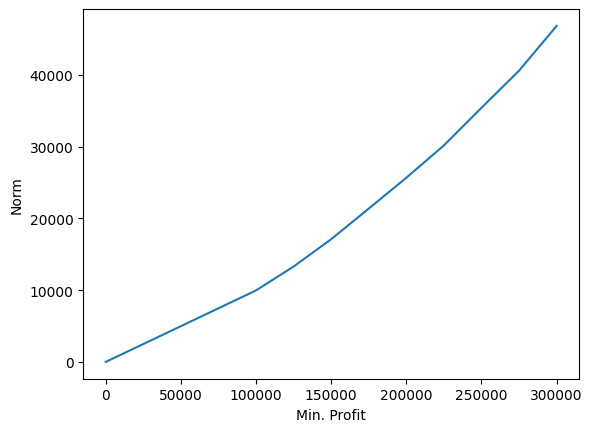

In [26]:
attempts = []
norm = []

for i in range(0, 300001, 25000):
    K.value = i
    opt = prob.solve()
    if opt == np.nan:
        break
    attempts.append(i)
    norm.append(opt)

plt.plot(attempts, norm)
plt.xlabel("Min. Profit")
plt.ylabel("Norm")
plt.show()

An optimal route with 200K minimum profit is calculated below. The objective function limited
goods purchased to around 8K units. For most commodities, this fulfills the original goal of
keeping the purchasing plan within available supply/demand. However, for popular goods like
Laranite, it may still exceed the available stock.

In [27]:
from collections import namedtuple

RoutePath = namedtuple("RoutePath", ["start", "end", "buy", "sell"])
Transaction = namedtuple("Transaction", ["loc_idx", "com_idx", "amount"])

def extract_transactions(array, locs, coms):
    non_zero = np.nonzero(array.value)
    items = []
    for i, idx in enumerate(non_zero[0]):
        col_idx = non_zero[1][i]
        amount = array[idx, col_idx].value
        commodity = coms[idx]
        location = locs[col_idx]
        items.append(Transaction(location, commodity, amount))
    return items


def extract_routes(steps, path_mat, buy_mat, sell_mat, locs, coms):
    paths = []
    for t in range(steps):
        non_zero = np.nonzero(path_mat[t].value)
        if len(non_zero[0]) == 0:
            break
        start_idx = non_zero[0][0]
        end_idx = non_zero[1][0]
        start_loc = locs[start_idx]
        end_loc = locs[end_idx]
        buy = extract_transactions(buy_mat[t], locs, coms)
        sell = extract_transactions(sell_mat[t], locs, coms)
        paths.append(RoutePath(start_loc, end_loc, buy, sell))
    return paths


def print_plan(routes):
    for path in routes:
        print("---------------------------------------------")
        print("Start: " + loc_idx[path.start])
        print("End: " + loc_idx[path.end])
        print("Buy:")
        for item in path.buy:
            print("\t%f units of %s" % (item.amount, com_idx[item.com_idx]))
        print("Sell")
        for item in path.sell:
            print("\t%f units of %s" % (item.amount, com_idx[item.com_idx]))

K.value = 200000
prob.solve()
routes = extract_routes(T, X, I, L, loc_selected, com_selected)
print_plan(routes)

---------------------------------------------
Start: start
End: Stanton > ArcCorp > Lyria > Shubin Mining Facility SAL-2
Buy:
	5000.000000 units of Agricium
	417.555938 units of Corundum
	12836.488812 units of Titanium
Sell
---------------------------------------------
Start: Stanton > ArcCorp > Lyria > Shubin Mining Facility SAL-2
End: Stanton > ArcCorp > Wala > Shady Glen Farms
Buy:
	12836.488812 units of Distilled Spirits
	12836.488812 units of Processed Food
Sell
---------------------------------------------
Start: Stanton > ArcCorp > Wala > Shady Glen Farms
End: Stanton > ArcCorp > Wala > ArcCorp Mining Area 056
Buy:
	12836.488812 units of Astatine
	12836.488812 units of Diamond
	12836.488812 units of Laranite
	12836.488812 units of Tungsten
Sell
	12836.488812 units of Distilled Spirits
	12836.488812 units of Processed Food
---------------------------------------------
Start: Stanton > ArcCorp > Wala > ArcCorp Mining Area 056
End: Stanton > ArcCorp > Area18 > Trade and Development

## Discussion

Without gathering specific data on the supply and demand information, the pessimistic loss can
serve as a good starting point for a trade route that tries to limit the effect of shortages. With
sufficient data, using the more explicit formulation may result in more profit over time. After all,
the pessimistic formulation can be seen as an approximation of
$Pr(L'(d, \theta) - L(d, \theta) > \delta) < \epsilon$ where the routes considered are the ones that
exceeds the $K$ theoretical profits. Then, minimizing the amount of goods purchased and sold is equivalent
finding a route that minimizes $\delta$ and $\epsilon$ for some distribution of $\theta$. Furthermore,
since all the commodities are treated equally, it is assumed that the distribution of supply/demand is
similar for all commodities. However, by weighting the commodities differently in the cost function, the pessimistic
approach can also capture some differences in the distribution of different commodities.

From a calculation perspective, the parametrization by time is not ideal. For each different timesteps, the
problem has to be re-initialized. Furthermore, the number of variables increases linearly with the number
of time steps. With more locations included in the problem, this may place a great burden on the
solver. Thus, by assuming that the price, supply, and demand remains constant during the run, there may
be a formulation that does not parametrize by time. If that is accomplished, then the number of
variables can stay constant with constant locations. For different maximum timesteps, the problem would
not need to be re-initialized.